# Deep Audio Classifier

## 1. Import Dependencies

In [1]:
import os
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## 2. Build Data Loading Function

### 2.1 Define Path to Files

OS Module:
- Python provides functions for interacting with the operating system.
- OS comes under Python’s standard utility modules.
- This module provides a portable way of using operating system dependent functionality.
- os.path module is sub-module of OS module in Python used for common pathname manipulation.

In [2]:
#os.listdir('/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing')

['Parsed_Not_Capuchinbird_Clips',
 'Forest Recordings',
 'Parsed_Capuchinbird_Clips']

In [3]:
#CAPUCHIN_FILE = os.path.join('../input/z-by-hp-unlocked-challenge-3-signal-processing', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
#NOT_CAPUCHIN_FILE = os.path.join('../input/z-by-hp-unlocked-challenge-3-signal-processing', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

CAPUCHIN_FILE = os.path.join('source', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('source', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

Reach specific capuchin and non capuchin bird audio record path

## 2.2 Build Data Loading Function

- MP3 files can have a bitrate that ranges from 90kbps to 320kbps, a huge difference from WAV files that generally have a bitrate of 1,411 kbps at 16 bit. 
- This difference in bitrate alone shows the loss of quality when MP3s are compressed.

wav: 
- Uncompressed audio. 
- It stores audio at about 10 MB per minute at a 44.1 kHz sample rate using stereo 16-bit samples. 
- The WAV format is by definition, the highest quality 16-bit audio format

In [4]:
# this function decodes our audio file
def load_wav_16k_mono(filename):
    # load encoded wav file
    file_contents = tf.io.read_file(filename)
    # decode wav (tensors by channel)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    
    # remove trailing axis
    wav = tf.squeeze(wav, axis=1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # goes from 44.1kHz to 16kHz: amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    
    return wav

wav_16k_mono: 
- mono(single channel) type audio
- 16kHz instead of 44.1kHz

In [5]:
f_c = tf.io.read_file(CAPUCHIN_FILE)

2022-12-26 05:53:48.607915: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-26 05:53:48.700037: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-26 05:53:48.700881: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-26 05:53:48.703274: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

audio to string

In [7]:
w, s_r = tf.audio.decode_wav(f_c, desired_channels=1)

In [8]:
w

<tf.Tensor: shape=(132300, 1), dtype=float32, numpy=
array([[-0.11117554],
       [-0.0378418 ],
       [ 0.05856323],
       ...,
       [-0.01077271],
       [-0.03436279],
       [-0.04879761]], dtype=float32)>

representation the amplitude of the wav

In [9]:
s_r

<tf.Tensor: shape=(), dtype=int32, numpy=44100>

frequency: 44100 Hz. we need to resample 16k

In [10]:
w = tfio.audio.resample(w, rate_in=44100, rate_out=16000)

2022-12-26 05:53:51.535152: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 AVX512F FMA
2022-12-26 05:53:51.745916: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [11]:
w

<tf.Tensor: shape=(48000, 1), dtype=float32, numpy=
array([[ 8.9910554e-07],
       [-2.7947258e-06],
       [ 7.0741157e-06],
       ...,
       [-1.0823049e-02],
       [-3.5766482e-03],
       [ 1.5143131e-02]], dtype=float32)>

downsized 132300 to 48000

## 2.3 Plot Wave

In [12]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

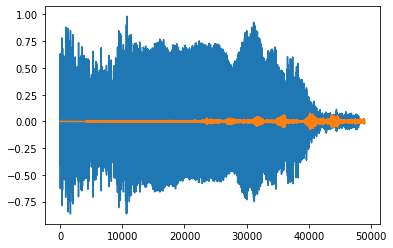

In [13]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

- blue: capuchin birds
- orange: another bird

## 3. Create Tensorflow Dataset

### 3.1 Define Paths to Positive and Negative Data

In [46]:
#POS = os.path.join('/kaggle/input','z-by-hp-unlocked-challenge-3-signal-processing','Parsed_Capuchinbird_Clips')
#NEG = os.path.join('/kaggle/input','z-by-hp-unlocked-challenge-3-signal-processing','Parsed_Not_Capuchinbird_Clips')

POS = os.path.join('source','Parsed_Capuchinbird_Clips')
NEG = os.path.join('source','Parsed_Not_Capuchinbird_Clips')

reach all wav files paths

### 3.2 Create Tensorflow Datasets

In [47]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

catch wav files from paths

### 3.3 Add Labels and Combine Positive and Negative Samples

In [48]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

this method filling array like all positives are 1 and all negatives are 0

## 4. Determine Average Length of a Capuchin Call

### 4.1 Calculate Wave Cycle Length

In [49]:
#lengths = []
#for file in os.listdir(os.path.join('../input/z-by-hp-unlocked-challenge-3-signal-processing', 'Parsed_Capuchinbird_Clips')):
#    tensor_wave = load_wav_16k_mono(os.path.join('../input/z-by-hp-unlocked-challenge-3-signal-processing', 'Parsed_Capuchinbird_Clips', file))
#    lengths.append(len(tensor_wave))
    
lengths = []
for file in os.listdir(os.path.join('source', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('source', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))    

slice through bigger clip for capturing the calls

### 4.2 Calculate Mean, Min and Max

In [50]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [51]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [52]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

- 54156 / 16000 = 3.38475 is average capuchinbird call time
- 32000 / 16000 = 2
- 80000 / 16000 = 5

## 5. Build Preprocessing Function to Convert to Spectrogram

### 5.1 Build Preprocessing Function

In [53]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    
    return spectrogram, label

- load data into wav form
- take first 48000 steps of all signals
- if audio length large then fill above 48000 steps with 0
- overriding zeros on sample
- (create spectrogram) stft: short time fourier transform
- absolute everything
- expand_dims: encapsulate a spectrogram in set of arrays

### 5.2 Test Out the Function and Visualize Spectogram

In [54]:
# test out
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [55]:
spectrogram, label = preprocess(filepath, label)

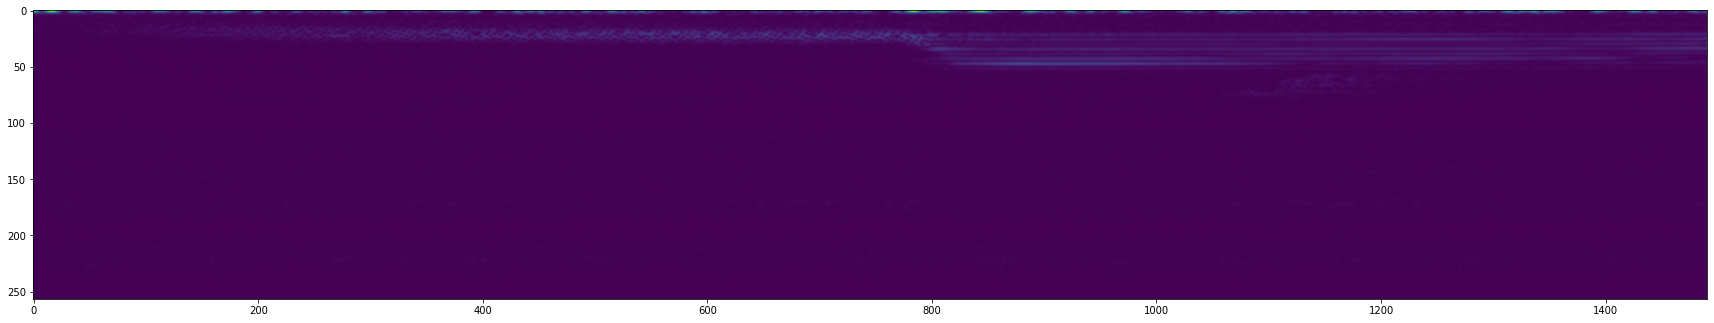

In [56]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

that spectrogram shows us is capbird call how looks in signals

In [57]:
filepath0, label0 = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [58]:
spectrogram0, label0 = preprocess(filepath0, label0)

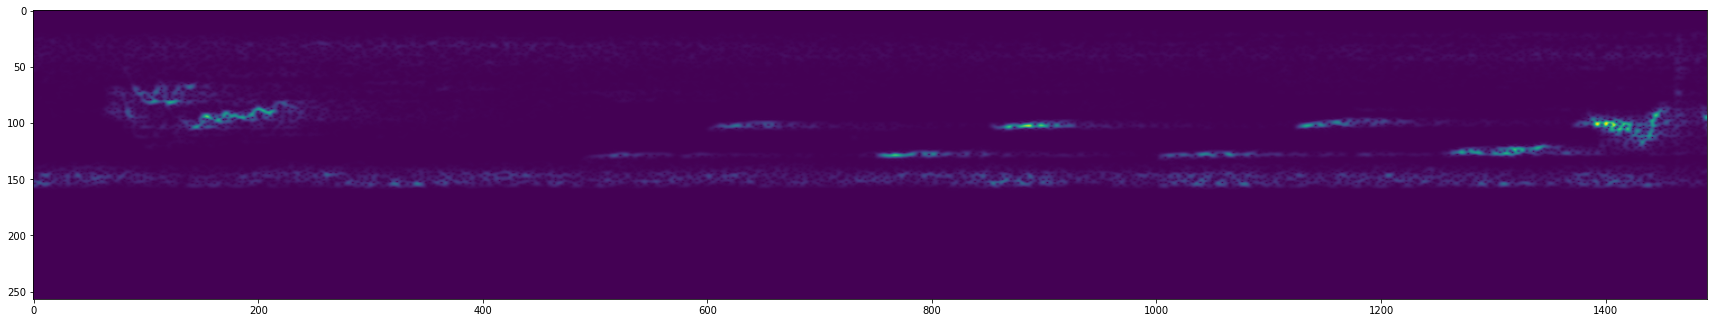

In [59]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram0)[0])
plt.show()

that spectrogram also shows us is not capbird call how looks in signals. how different!

## 6. Create Training and Testing Partitions

### 6.1 Create a Tensorflow Data Pipeline

In [60]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

- map: preprocess data on spectrogram method
- shuffle: mix neg and pos
- batch: train on 16 samples at a time
- prefetch: eliminate any cpu bottlenecking

### 6.2 Split into Training and Testing Partitions

In [61]:
len(data)*0.7

35.699999999999996

In [62]:
train = data.take(36)
test = data.skip(36).take(15)

- take 36 (%70) for training
- skip data that grabs for training
- take 15 (%30) for test

### 6.3 Test One Batch

In [63]:
samples, labels = train.as_numpy_iterator().next()

2022-12-26 06:11:22.115225: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 389 of 1000
2022-12-26 06:11:32.178914: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 572 of 1000
2022-12-26 06:11:42.114460: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 745 of 1000
2022-12-26 06:11:45.533464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


In [64]:
samples.shape

(16, 1491, 257, 1)

16 different example

## 7. Build Deep Learning Model

### 7.1 Load Tensorflow Dependencies

In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

### 7.2 Build Sequential Model, Compile and View Summary

In [66]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257, 1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

- relu: rectified linear units
- The ReLU function is another non-linear activation function that has gained popularity in the deep learning domain.
- The main advantage of using the ReLU function over other activation functions is that it does not activate all the neurons at the same time.


- Conv2D: convolutional 2d
- cnn: convolutional neural network
- CNN is a kind of network architecture for deep learning algorithms and is specifically used for image recognition and tasks that involve the processing of pixel data.
- There are other types of neural networks in deep learning, but for identifying and recognizing objects, CNNs are the network architecture of choice.


- The Sigmoid function performs the role of an activation function in machine learning which is used to add non-linearity in a machine learning model.
- Basically, the function determines which value to pass as output and what not to pass as output.
- When the activation function for a neuron is a sigmoid function it is a guarantee that the output of this unit will always be between 0 and 1.


- Flattening is converting the data into a 1-dimensional array for inputting it to the next layer. We flatten the output of the convolutional layers to create a single long feature vector.
- Dense Layer is simple layer of neurons in which each neuron receives input from all the neurons of previous layer, thus called as dense.
- Dense Layer is used to classify image based on output from convolutional layers.
- Working of single neuron. A layer contains multiple number of such neurons.

In [67]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [68]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1489, 255, 16)     160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1487, 253, 16)     2320      
_________________________________________________________________
flatten (Flatten)            (None, 6019376)           0         
_________________________________________________________________
dense (Dense)                (None, 128)               770480256 
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 770,482,865
Trainable params: 770,482,865
Non-trainable params: 0
_________________________________________________________________


that is a neural network. about 771 million parameters that's huge

### 7.3 Fit Model, View Loss and KPI Plots

In [69]:
# my computer does not perform this operation effectively
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4


2022-12-26 06:12:08.740715: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


36/36 [==============================] - 16s 220ms/step - loss: 3.0692 - recall: 0.8662 - precision: 0.7953 - val_loss: 0.1141 - val_recall: 0.9839 - val_precision: 0.9531
Epoch 2/4
36/36 [==============================] - 7s 207ms/step - loss: 0.0680 - recall: 0.9568 - precision: 0.9810 - val_loss: 0.0460 - val_recall: 0.9661 - val_precision: 1.0000
Epoch 3/4
36/36 [==============================] - 7s 205ms/step - loss: 0.0530 - recall: 0.9812 - precision: 0.9812 - val_loss: 0.0486 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/4
36/36 [==============================] - 7s 205ms/step - loss: 0.1894 - recall: 0.9933 - precision: 1.0000 - val_loss: 0.0275 - val_recall: 1.0000 - val_precision: 1.0000


In [72]:
hist.history

{'loss': [3.0691888332366943,
  0.06800493597984314,
  0.053018298000097275,
  0.1894160956144333],
 'recall': [0.8662420511245728,
  0.9567901492118835,
  0.981249988079071,
  0.9932885766029358],
 'precision': [0.7953216433525085, 0.9810126423835754, 0.981249988079071, 1.0],
 'val_loss': [0.11409586668014526,
  0.046035557985305786,
  0.048566244542598724,
  0.027520302683115005],
 'val_recall': [0.9838709831237793, 0.9661017060279846, 1.0, 1.0],
 'val_precision': [0.953125, 1.0, 1.0, 1.0]}

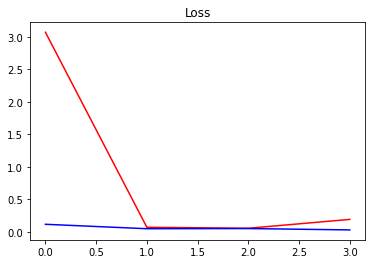

In [73]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

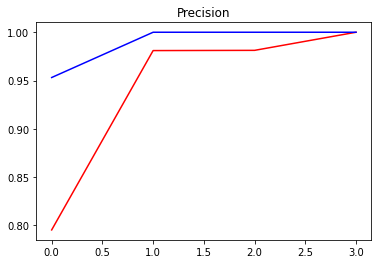

In [74]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

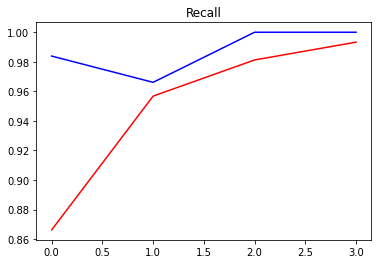

In [75]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

## 8. Make Prediction on Single Clip

### 8.1 Get One Batch and Make a Prediction

In [77]:
x_test, y_test = test.as_numpy_iterator().next()

In [78]:
yhat = model.predict(x_test)

### 8.2 Convert Logits to Classes

In [79]:
# pythonic for loop
yhat = [1 if prediction >0.5 else 0 for prediction in yhat]

## 9. Build Forest Parsing Functions

### 9.1 Load up MP3s

In [80]:
def load_mp3_16k_mono(filename):
    # convert float tensor
    res = tfio.audio.AudioIOTensor(filename)
    # convert to tensor and combine channels
    tensor = res.to_tensor()
    # turn into single channel
    tensor = tf.math.reduce_sum(tensor, axis=1)/2
    
    # extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # resample to 16kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    
    return wav

In [81]:
#mp3 = os.path.join('../input/z-by-hp-unlocked-challenge-3-signal-processing', 'Forest Recordings', 'recording_00.mp3')

mp3 = os.path.join('source', 'Forest Recordings', 'recording_00.mp3')

In [82]:
wav = load_mp3_16k_mono(mp3)

In [83]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

slice mp3 into equal length parts

In [84]:
samples, index = audio_slices.as_numpy_iterator().next()

### 9.2 Build Function to Convert Clips into Windowed Spectrograms

In [85]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample], 0)
    
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    
    return spectrogram

### 9.3 Convert Longer Clips into Windows and Make Predictions

In [86]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [87]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction >0.99 else 0 for prediction in yhat]

### 9.4 Group Consecutive Detections

In [88]:
from itertools import groupby

In [89]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [90]:
calls

5

## 10. Make Predictions

### 10.1 Loop Over all Recordings and Make Predictions

In [106]:
results = {}

#for file in os.listdir(os.path.join('../input','z-by-hp-unlocked-challenge-3-signal-processing', 'Forest Recordings')):
#    FILEPATH = os.path.join('../input','z-by-hp-unlocked-challenge-3-signal-processing', 'Forest Recordings', file)

for file in os.listdir(os.path.join('source', 'Forest Recordings')):
    FILEPATH = os.path.join('source', 'Forest Recordings', file)   
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

### 10.2 Convert Predictions into Classes

In [120]:
class_preds = {}

for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.999 else 0 for prediction in logits],

class_preds['recording_00.mp3']    

([0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],)

### 10.3 Group Consecutive Detections

In [121]:
postprocessed={}
for file,scores in class_preds.items():
    postprocessed[file]=tf.math.reduce_sum([key for key,group in groupby(scores)]).numpy()

postprocessed

{'recording_76.mp3': 0,
 'recording_62.mp3': 0,
 'recording_48.mp3': 12,
 'recording_44.mp3': 2,
 'recording_45.mp3': 8,
 'recording_06.mp3': 23,
 'recording_43.mp3': 10,
 'recording_68.mp3': 1,
 'recording_95.mp3': 5,
 'recording_17.mp3': 57,
 'recording_65.mp3': 5,
 'recording_74.mp3': 0,
 'recording_10.mp3': 9,
 'recording_49.mp3': 0,
 'recording_15.mp3': 3,
 'recording_37.mp3': 12,
 'recording_64.mp3': 5,
 'recording_39.mp3': 60,
 'recording_04.mp3': 23,
 'recording_28.mp3': 59,
 'recording_05.mp3': 0,
 'recording_80.mp3': 2,
 'recording_57.mp3': 5,
 'recording_12.mp3': 0,
 'recording_59.mp3': 60,
 'recording_67.mp3': 0,
 'recording_09.mp3': 0,
 'recording_79.mp3': 0,
 'recording_14.mp3': 0,
 'recording_63.mp3': 60,
 'recording_86.mp3': 60,
 'recording_47.mp3': 59,
 'recording_03.mp3': 0,
 'recording_33.mp3': 0,
 'recording_08.mp3': 40,
 'recording_51.mp3': 10,
 'recording_35.mp3': 0,
 'recording_81.mp3': 7,
 'recording_30.mp3': 3,
 'recording_88.mp3': 0,
 'recording_75.mp3': 2,
 '

I have made mistakes somewhere. I listen 'recording_00.mp3' it has 5 capuchin calls but here value is 8.

## 11. Export Results

In [122]:
import csv

In [124]:
with open('capuchinbird_results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    
    for key, value in postprocessed.items():
        writer.writerow([key, value])